# Clustering 分群法

## 目錄
---
1. Introduction
2. 資料前處理
3. 資料視覺化
4. 模型建置
    - 階層式分群(Hierachical Clustering)
        - Agglomerative Clustering
    - 切割式分群(Partitional Clustering)
        - K-Means
        - K-Medoid
5. 分群最佳數目
    - 手肘法(Elbow Method)
    - 平均側影法(Average silhouette Method)
6. 總結
7. 參考資源
--- 

## 1. Introduction
集群分析是一種非監督的機器學習方法，原理是依據樣本之間的共同屬性、特徵等，將比較相似的樣本聚集在一起，行程集群（cluster）。通常會以距離作為分群的依據，相對距離越近的話，相似程度越高，越有可能被分進同一群中。而分群的目標就是使各群內樣本差異小、各群間的差異大。

- 分群跟分類本質上是不同的方法，雖然都是將樣本點分門別類，但分類在訓練時有提供 label，屬於監督式學習，但因為已經事先給定分類的範圍與大小，可能找不到更細或更廣的資料範疇資訊。比如說：給定好的分類中其實還能更細分成其他小類別。

而在分群分析中，有兩個較難回答的問題：
- 什麼樣的個體適合被分在一個群體中？
- 這麼多樣本點必須分做幾群較適合？

一般來說，可以從兩個角度來思考：緊緻性(Compactness)跟連通性(Connectedness)
主要分成兩種類型：

- 緊緻性(Compactness)，會希望「個體之間的距離越小越好」，讓群體內部越緊緻越好：
    - 階層式分群(Hierarchical Clustering)：不需指定分群數目，讓資料自動由上往下/由下往上結合起來。
    - 分割式分群(Partitional Clustering)：需事先指定分群數目，經過不斷的迭代，直到群內的變異最小。
    
- 連通性(Connectedness)，會希望「可以串接的個體分在同一群」：
    - 譜分群(Spectral Clustering)：基於圖論跟Graph Laplacian的方法，能把「資料的形狀(shape)」考量進來
--------
現在我們要使用 sklearn 中的一個資料集 - iris 鳶尾花，用來示範集群分析的使用方式，在資料集當中，特徵是鳶尾屬花朵中所提取的花瓣花萼的長寬數據資料，依照山鳶尾、維吉尼雅鳶尾三類進行標示。


In [1]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 載入資料集

In [2]:
iris = datasets.load_iris()

In [3]:
x = pd.DataFrame(iris.data, columns = iris.feature_names)
y = pd.DataFrame(iris.target, columns = ['target'])
data = pd.concat([x, y], axis = 1)

資料集當中有 150 筆資料，其中每筆資料中都有四個關於花瓣長寬的 feature。

In [4]:
data.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


## 2. 資料前處理
因為現在要示範的事分群分析，因此除了切分成訓練與測試資料以外，我們也要在訓練階段的時候先將 label 拿掉，才能進行非監督式學習。

In [6]:
# 只使用 x_train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## 3. 資料視覺化
在進行分群之前，我們可以先利用資料視覺化的方式來了解資料的分佈情形

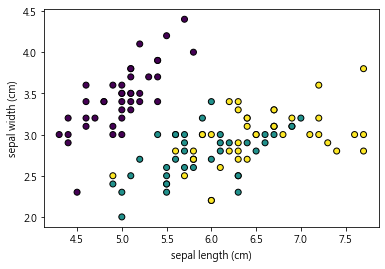

In [7]:
plt.scatter(x_train.loc[:, "sepal length (cm)"], x_train.loc[:, "sepal width (cm)"]
            , c = y_train.loc[:, "target"], edgecolor= 'k')
plt.xlabel("sepal length (cm)")
plt.ylabel("sepal width (cm)")
plt.show()

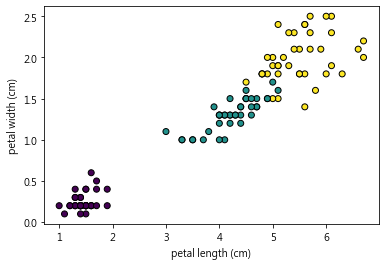

In [8]:
plt.scatter(x_train.loc[:, "petal length (cm)"], x_train.loc[:, "petal width (cm)"]
            , c = y_train.loc[:, "target"], edgecolor= 'k')
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.show()

## 4. 模型建置
接下來模型建置的部分會示範兩類常見的分群方法，分別是：
- 階層式分群(Hierarchical Clustering)
- 切割式分群(Partitional Clustering)
    - K-Means
    - K-Medoid

### 階層式分群(Hierachical Clustering)
階層式分群法即是一種階層架構的方式，將資料層層反覆地進行分裂或聚合，最後生成樹狀的結構，常見的方式有兩種
- 聚合：一開始每個樣本點自為一群，接著一步步跟其他樣本點（群）聚合，最後變成群集
- 分裂：一開始所有樣本點都視為一群，再一步步的從中分離出小群集

我們以較常見的凝聚分層法(Agglomerative)來講解：
該方法一開始時，視每個樣本點都是一群，接著用 greedy 的方式，每次都找距離最近的兩個個體合成一群，漸漸的群組數就會慢慢降低，若做到結束時，群集會只剩下 1 群。

然而，如何去衡量兩個群集之間的距離呢？這個距離該如何被定義，有以下幾種方法：
- 單一連結聚合演算法（single-linkage agglomerative algorithm）：群聚與群聚間的距離可以定義為不同群聚中最接近兩點間的距離<br>                             $d(C_i, C_j)=\min_{\mathbf{a}\in C_i, \mathbf{b}\in C_j} d(\mathbf{a}, \mathbf{b})$
- 完整連結聚合演算法（complete-linkage agglomerative algorithm）：群聚間的距離定義為不同群聚中最遠兩點間的距離：<br>
$d(C_i, C_j)=\max_{\mathbf{a}\in C_i, \mathbf{b}\in C_j} d(\mathbf{a}, \mathbf{b})$
- 平均連結聚合演算法（average-linkage agglomerative algorithm）：群聚間的距離則定義為不同群聚間各點與各點間距離總和的平均。<br>
$d(C_i, C_j)=\sum_{\mathbf{a}\in C_i, \mathbf{b}\in C_j} \frac{d(\mathbf{a}, \mathbf{b})}{|C_i||C_j|},$
- 沃德法（Ward's method）：群聚間的距離定義為在將兩群合併後，各點到合併後的群中心的距離平方和。<br>
$d(C_i, C_j)=\sum_{\mathbf{a}\in C_i \cup C_j} \|\mathbf{a}-\mathbf{\mu}\|,$
----
原理很容易理解，接下來我們使用 sklearn 中的 AgglomerativeClustering 來進行示範！

In [9]:
from sklearn.cluster import AgglomerativeClustering

說明一下參數的部分：
- n_clusters: 可以指定最多要分幾群
- affinity: 計算距離的方式，主要有“euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”，預設是歐式距離，常用的 cosine 相似度也可以使用。
- linkage: 該方法中如何去計算群集與群集之間距離的方法，同上面講述的有 ‘ward’, ‘complete’, ‘average’, ‘single’，預設為 ward 法

我們先比較不同種類距離計算法的差別，假設我們分群的數量固定為 3，一開始使用 single 的方式，計算兩個集群之間最近的距離作為代表，可以發現分類的效果不太好。

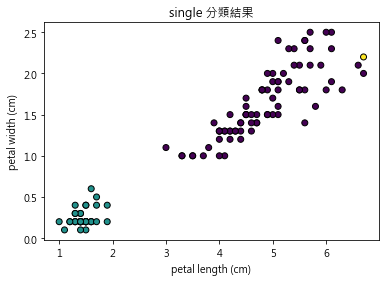

In [10]:
clustering_single = AgglomerativeClustering(n_clusters = 3
                                    , affinity = "euclidean"
                                    , linkage = "single")
clustering_single.fit(x_train)

plt.scatter(x_train.loc[:, "petal length (cm)"], x_train.loc[:, "petal width (cm)"]
            , c = clustering_single.labels_, edgecolor= 'k')
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.title("single 分類結果")
plt.show()

接下來是使用 complete 的方法，可以發現能夠接近原本資料型態的分佈，分得相當不錯

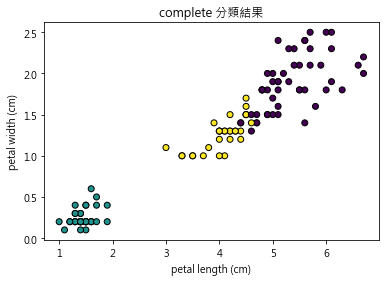

In [11]:
clustering_complete = AgglomerativeClustering(n_clusters = 3
                                    , affinity = "euclidean"
                                    , linkage = "complete")
clustering_complete.fit(x_train)

plt.scatter(x_train.loc[:, "petal length (cm)"], x_train.loc[:, "petal width (cm)"]
            , c = clustering_complete.labels_, edgecolor= 'k')
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.title("complete 分類結果")
plt.show()

若使用 ward 的方法，效果也相當不錯

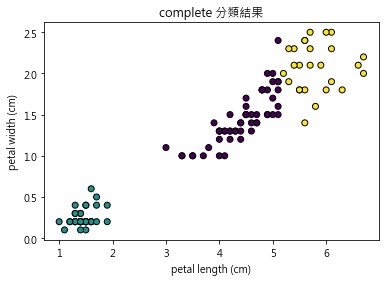

In [12]:
clustering_ward = AgglomerativeClustering(n_clusters = 3
                                    , affinity = "euclidean"
                                    , linkage = "ward")
clustering_ward.fit(x_train)

plt.scatter(x_train.loc[:, "petal length (cm)"], x_train.loc[:, "petal width (cm)"]
            , c = clustering_ward.labels_, edgecolor= 'k')
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.title("complete 分類結果")
plt.show()

比較與原本的分類結果，可以發現在鳶尾花的這個例子中，使用 complete 作為距離量測方法最適合，single 的方法最差。根據資料的型態，選擇不同的方法會有不同的效果，complete 通常較為嚴謹，因此在分類時能夠有較不偏誤的結果，相對而言，single 較為鬆散，但對於新聞分類、做新聞懶人包等的情境卻非常適合。

-------
再來，展示一下使用 AgglomerativeClustering 所產生的樹狀圖，以 complete 為例：
https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py

In [13]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

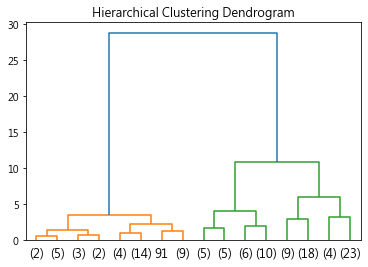

In [14]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, compute_full_tree=True).fit(x_train)

plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.show()

### 切割式分群(Partitional Clustering)
在切割式分群裡，我們常用 k-Cluster 的方法，該方法又根據分群條件的不同，可以分成
- K-Means
- K-Medoid

接下來會對這兩種切割式分群的方法來進行示範

----
#### K-Means
簡單說明一下 K-means 運作的流程：
1. 先設定要分幾群（K群）
2. 隨機找 K 個樣本點做出使得群的“重心”
3. 對每個資料計算距離這 K 個重心的距離，最後該筆資料分給距離最短的那群
4. 每筆資料都被分到 k 群中，對每一群的資料計算重心
5. 重複直到收斂

In [15]:
from sklearn.cluster import KMeans

簡單說明會用到的參數：
- n_clusters：分成幾群
- max_iter： 最大重複幾個迭代

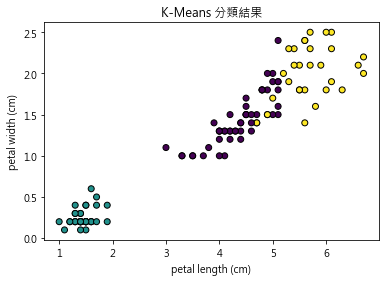

In [16]:
kmeans = KMeans(n_clusters=3, max_iter=600).fit(x_train)

plt.scatter(x_train.loc[:, "petal length (cm)"], x_train.loc[:, "petal width (cm)"]
            , c = kmeans.labels_, edgecolor= 'k')
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.title("K-Means 分類結果")
plt.show()

接下來，我們來看真實的 label 資料與分群過後的差別吧

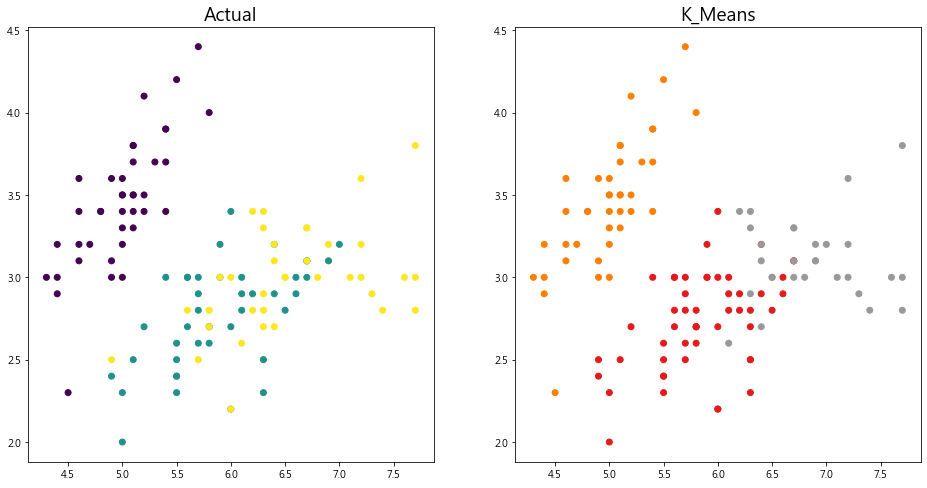

In [17]:
df = x_train.copy()
df['k_means'] = kmeans.predict(df)
df['target']= y_train['target']
df =  df.reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(df["sepal length (cm)"], df["sepal width (cm)"], c=df['target'])
axes[1].scatter(df["sepal length (cm)"], df["sepal width (cm)"], c=df['k_means'], cmap=plt.cm.Set1)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('K_Means', fontsize=18)
plt.show()

### K-Medoid
關於 K-Medoid 的流程，大致上與 K-Means 類似，但又不太一樣：
1. 先設定要分幾群（K群）
2. 隨機找 K 個樣本點做出使得群的“重心”
3. 對每個資料計算距離這 K 個重心的距離，最後該筆資料分給距離最短的那群
4. 每筆資料都被分到 k 群中，對每一群的資料計算重心
5. **從該群資料點當中找到離重心最近的距離作為該群的新重心**
6. 重複直到收斂

**注意：必須 pip install scikit-learn-extra  ***

In [18]:
from sklearn_extra.cluster import KMedoids

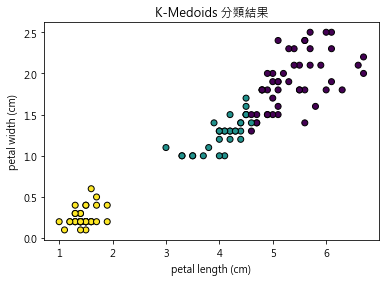

In [19]:
kmedoids = KMedoids(n_clusters=3, random_state=5)
kmedoids.fit(x_train)

plt.scatter(x_train.loc[:, "petal length (cm)"], x_train.loc[:, "petal width (cm)"]
            , c = kmedoids.labels_, edgecolor= 'k')
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.title("K-Medoids 分類結果")
plt.show()

## 5. 分群的最佳數目(Optimal number of clusters)
剛剛前面都直接決定該分幾群，然而因為 clustering 並不會直接告訴你該分幾群才是最好的，因此我們有必要探討“選幾群”最好這個問題。

### 手肘法(Elbow Method)。

至於選幾群才是最好，最常見到的方法稱為手肘法(Elbow Method)。
說明手肘法之前我們必須先思考何謂“好的分群”？答案是「使群內的總變異最小；使群間的總變異最大」，所以我我們必須找到一個數字 n 群，使得資料被分做 n 群時，群內的總變異(SSE)會最小，那麼該 n 就是最佳的分群數目。這時候你可能會問說，今天分的群數越多，總變異就會越小啊！但群數越多不一定越好，那怎麼辦？

因此手軸法利用繪圖的方式觀察 SSE 的變化，找到肘點作為合適的 n，觀察是否在 n 時總變異的變化最為劇烈，說起來有點複雜，還是乾脆直接用例子來表示！


In [20]:
distortions = []
# 1~10群
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(x_train)
    distortions.append(kmeanModel.inertia_)

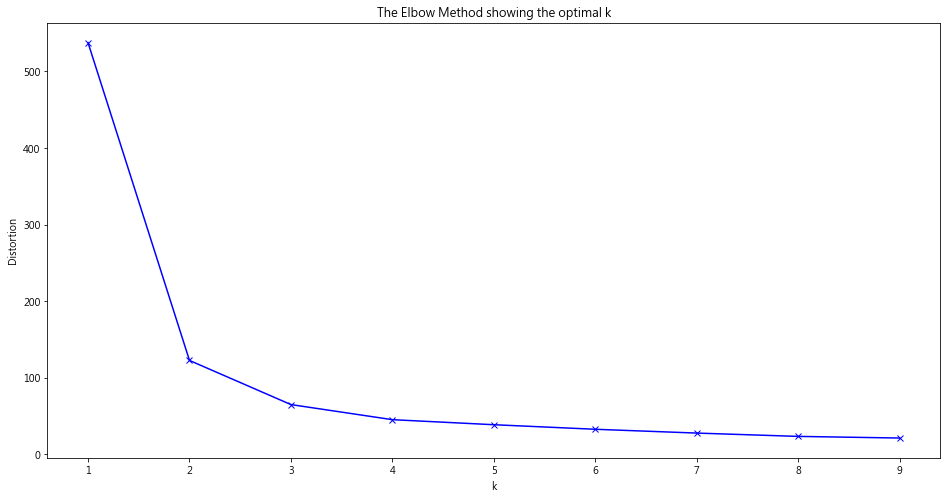

In [21]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

從上述結果來看，可以發現當 n = 3 的時候可以使 SSE 最小，因此可以選擇 3 作為分群數目。另一方面，有時候類似的轉折點可能會不止一個，換句話說，肘點可能會有很多個，這時候可能要搭配 domain knowledge 來衡量。

### 平均側影法(Average silhouette Method)
另一種用來衡量分群效果的方法，又稱為輪廓分析，主要的想法是去計算側影係數(Silhouette Coefficient)，根據每個資料點(i)的內聚力和分散力，衡量分群的效果。
白話來講，側影係數越高，代表該點越適合在該群中。

以下是程式碼示範：

In [22]:
from sklearn.metrics import silhouette_score
silhouette_avg = []
K = range(2,10)

for k in K:
    kmeansModel = KMeans(n_clusters = k).fit(x_train)
    silhouette_avg.append(silhouette_score(x_train, kmeansModel.labels_))

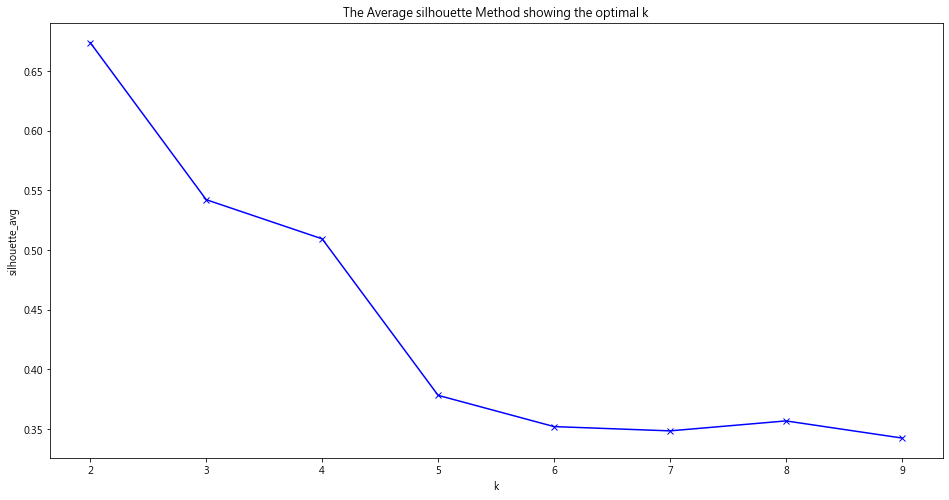

In [23]:
plt.figure(figsize=(16,8))
plt.plot(K, silhouette_avg, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_avg')
plt.title('The Average silhouette Method showing the optimal k')
plt.show()

從結果來看可能會覺得，娃～～涼去！怎麼只有兩群呢？其實只要看當初視覺化的圖，就可以知道答案了！

## 6. 總結
分群(clustering)屬於一種非監督式的機器學習方法，不依靠 labels，而是根據資料本身的特性來進行分析的一種方法。通常用在當我們對原始資料並沒有那麼理解、或者欠缺專業知識背景時，可以使用的一種方法，透過分群，可以使一些肉眼難以觀察出來的資料特性顯露出來，使我們對資料能夠有初步的理解與認識。

另外，從範例中很明顯的可以發現在分群的問題中，分幾群是相當重要問題，因此必須配合適當的方法以及專業知識，才能夠有好的結果出現。

## 7. 參考資源
- R筆記–(9)分群分析(Clustering) <br>
https://www.rpubs.com/skydome20/R-Note9-Clustering
- 3-2 Hierarchical Clustering (階層式分群法)<br>
http://mirlab.org/jang/books/dcpr/dcHierClustering.asp?title=3-2%20Hierarchical%20Clustering%20(%B6%A5%BCh%A6%A1%A4%C0%B8s%AAk)&language=chinese
- 機器學習: 集群分析 K-means Clustering<br>
https://chih-sheng-huang821.medium.com/機器學習-集群分析-k-means-clustering-e608a7fe1b43
- sklearn agglomerativeClustering<br>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
- KMeans<br>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- Elbow<br>
https://predictivehacks.com/k-means-elbow-method-code-for-python/
- Kmeans分群演算法 與 Silhouette 輪廓分析<br>
https://medium.com/@jimmy_huang/kmeans分群演算法-與-silhouette-輪廓分析-8be17e634589